<a href="https://colab.research.google.com/github/cmosquera15/Entregas-Proyecto-Modelos-I-2025.2/blob/main/03%20-%20modelo%20con%20preprocesado%20Escalado%2BEncodings%20y%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [ ]:
!pip install -q kaggle category_encoders

import os, json, time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from collections import defaultdict

RND = 42
np.random.seed(RND)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.9 MB/s eta 0:00:00


# Carga de datos desde Kaggle

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
data = {"username":"josemiguelc1","key":"1a8778db87047d4dc2602b6e2395bf36"}
with open('kaggle.json','w') as f: json.dump(data, f)
!chmod 600 kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -q
!unzip -q '*.zip'

df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("train shape:", df.shape, " test shape:", test_df.shape)

replicating local resources
train shape: (692500, 21)  test shape: (296786, 20)


# Inspección ligera

In [ ]:
print("Valores faltantes por columna (train):")
print(df.isna().sum())
print("\nTipos:")
print(df.dtypes)
print("\nDistribución objetivo:")
print(df["RENDIMIENTO_GLOBAL"].value_counts())

Valores faltantes por columna (train):
ID                                 0
PERIODO_ACADEMICO                  0
E_PRGM_ACADEMICO                   0
E_PRGM_DEPARTAMENTO                0
E_VALORMATRICULAUNIVERSIDAD     6287
E_HORASSEMANATRABAJA           30857
F_ESTRATOVIVIENDA              32137
F_TIENEINTERNET                26629
F_EDUCACIONPADRE               23178
F_TIENELAVADORA                39773
F_TIENEAUTOMOVIL               43623
E_PRIVADO_LIBERTAD                 0
E_PAGOMATRICULAPROPIO           6498
F_TIENECOMPUTADOR              38103
F_TIENEINTERNET.1              26629
F_EDUCACIONMADRE               23664
RENDIMIENTO_GLOBAL                 0
INDICADOR_1                        0
INDICADOR_2                        0
INDICADOR_3                        0
INDICADOR_4                        0
dtype: int64

Tipos:
ID                               int64
PERIODO_ACADEMICO                int64
E_PRGM_ACADEMICO                object
E_PRGM_DEPARTAMENTO             object
E_VALOR

# Preparación inicial (imputación sencilla y mapeos)

In [ ]:
df = df.copy()
test_df = test_df.copy()

rend_map = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
y_full = df['RENDIMIENTO_GLOBAL'].map(rend_map).astype(int)
df = df.drop(columns=['RENDIMIENTO_GLOBAL'])

cat_fill_noinfo = ['F_EDUCACIONMADRE', 'F_EDUCACIONPADRE', 'E_VALORMATRICULAUNIVERSIDAD',
                   'F_ESTRATOVIVIENDA', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO']
for c in cat_fill_noinfo:
    if c in df.columns:
        df[c] = df[c].fillna('no info')
    if c in test_df.columns:
        test_df[c] = test_df[c].fillna('no info')

cmap = {
    'Menos de 500 mil': 0.25,
    'Entre 500 mil y menos de 1 millón': 0.75,
    'Entre 1 millón y menos de 2.5 millones': 1.75,
    'Entre 2.5 millones y menos de 4 millones': 3.25,
    'Entre 4 millones y menos de 5.5 millones': 4.75,
    'Entre 5.5 millones y menos de 7 millones': 6.25,
    'Más de 7 millones': 7.75,
    'No pagó matrícula': 0.0,
    'no info': -1.0
}
def map_matricula_col(df_local):
    if 'E_VALORMATRICULAUNIVERSIDAD' in df_local.columns:
        if df_local['E_VALORMATRICULAUNIVERSIDAD'].dtype == object:
            df_local['E_VALORMATRICULANUM'] = (
                df_local['E_VALORMATRICULAUNIVERSIDAD']
                .replace({'No sabe':'no info','No Aplica':'no info'})
                .map(cmap)
            )
        else:
            df_local['E_VALORMATRICULANUM'] = pd.to_numeric(df_local['E_VALORMATRICULAUNIVERSIDAD'], errors='coerce')
    else:
        df_local['E_VALORMATRICULANUM'] = -1.0

map_matricula_col(df)
map_matricula_col(test_df)

hours_map = {
    '0': 0, '0 horas': 0, 'Menos de 10 horas': 5, 'Menos de 10 horas.': 5,
    'Entre 10 y 20 horas': 15, 'Entre 11 y 20 horas': 15,
    'Entre 21 y 30 horas': 25, 'Entre 21 y 30 horas.': 25,
    'Más de 30 horas': 40, 'no info': -1
}
def map_hours(df_local):
    if 'E_HORASSEMANATRABAJA' in df_local.columns:
        if df_local['E_HORASSEMANATRABAJA'].dtype == object:
            df_local['E_HORASSEMANATRABAJA_NUM'] = (
                df_local['E_HORASSEMANATRABAJA']
                .replace({'No sabe':'no info','No Aplica':'no info'})
                .map(lambda x: hours_map.get(x, -1))
            )
        else:
            df_local['E_HORASSEMANATRABAJA_NUM'] = pd.to_numeric(df_local['E_HORASSEMANATRABAJA'], errors='coerce').fillna(-1)
    else:
        df_local['E_HORASSEMANATRABAJA_NUM'] = -1

map_hours(df)
map_hours(test_df)

bin_cols = [c for c in ['F_TIENEINTERNET','F_TIENELAVADORA','F_TIENEAUTOMOVIL',
                        'E_PRIVADO_LIBERTAD','E_PAGOMATRICULAPROPIO','F_TIENECOMPUTADOR',
                        'F_TIENEINTERNET.1'] if c in df.columns or c in test_df.columns]

def binarize_col(series):
    return series.fillna('no info').apply(
        lambda x: 1 if str(x).strip().lower() in ['si','sí','s'] else (
                  0 if str(x).strip().lower() in ['no','n'] else -1)
    ).astype(int)

for c in bin_cols:
    if c in df.columns:
        df[c] = binarize_col(df[c])
    if c in test_df.columns:
        test_df[c] = binarize_col(test_df[c])

for ind in ['INDICADOR_1','INDICADOR_2','INDICADOR_3','INDICADOR_4']:
    if ind in df.columns:
        df[ind] = pd.to_numeric(df[ind], errors='coerce')
    if ind in test_df.columns:
        test_df[ind] = pd.to_numeric(test_df[ind], errors='coerce')

print("Imputación y mapeos iniciales terminados.")
print("train shape:", df.shape, " test shape:", test_df.shape)

Imputación y mapeos iniciales terminados.
train shape: (692500, 22)  test shape: (296786, 22)


# Agrupar categorías raras (< threshold) -> 'other'

In [ ]:
RARE_TH = 100
cat_cols = [c for c in df.select_dtypes(include='object').columns.tolist() if c not in ('RENDIMIENTO_GLOBAL',)]
print("Categorical candidate columns:", cat_cols)

def group_rare_categories(train_series, val_series_list=[], threshold=RARE_TH):
    counts = train_series.value_counts()
    rares = counts[counts < threshold].index.tolist()
    train_mod = train_series.replace(rares, 'other')
    val_mods = [s.replace(rares, 'other') for s in val_series_list]
    return train_mod, val_mods

freq_cols = []
if 'E_PRGM_ACADEMICO' in df.columns: freq_cols.append('E_PRGM_ACADEMICO')
if 'E_PRGM_DEPARTAMENTO' in df.columns: freq_cols.append('E_PRGM_DEPARTAMENTO')

te_candidates = [c for c in cat_cols if c not in freq_cols]
print("Frequency-encoded columns:", freq_cols)
print("Target-encode candidates:", te_candidates)

Categorical candidate columns: ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']
Frequency-encoded columns: ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO']
Target-encode candidates: ['E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']


# Dividir el entrenamiento/validación antes de calcular las codificaciones

In [ ]:
X_tmp = df.copy()
y_tmp = y_full.copy()
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.20, random_state=RND, stratify=y_tmp)
print("Split shapes:", X_train.shape, X_val.shape)

for c in te_candidates + freq_cols:
    if c in X_train.columns:
        X_train[c], _ = group_rare_categories(X_train[c], [], threshold=RARE_TH)
        valid_cats = X_train[c].unique().tolist()
        X_val[c] = X_val[c].apply(lambda x: x if x in valid_cats else 'other')
        test_df[c] = test_df[c].apply(lambda x: x if x in valid_cats else 'other')
        df[c] = df[c].apply(lambda x: x if x in valid_cats else 'other')

Split shapes: (554000, 22) (138500, 22)


# Codificación de frecuencia (basada en Train)

In [ ]:
def frequency_encode(train_series):
    freq = train_series.value_counts(normalize=True)
    return freq.to_dict()

freq_maps = {}
for c in freq_cols:
    if c in X_train.columns:
        fmap = frequency_encode(X_train[c])
        freq_maps[c] = fmap
        X_train[c+'_freq'] = X_train[c].map(fmap).fillna(0.0)
        X_val[c+'_freq'] = X_val[c].map(fmap).fillna(0.0)
        test_df[c+'_freq'] = test_df[c].map(fmap).fillna(0.0)

# Target encoding con smoothing (similar a K-fold mediante prior global)

In [ ]:
target_enc_maps = {}
smoothing_k = 10.0

global_prior = y_train.mean()
for c in te_candidates:
    if c in X_train.columns:
        agg = pd.concat([X_train[c], y_train], axis=1).groupby(c).agg(['mean','count'])[y_train.name]
        agg.columns = ['mean', 'count']
        agg['te'] = (agg['mean'] * agg['count'] + global_prior * smoothing_k) / (agg['count'] + smoothing_k)
        te_map = agg['te'].to_dict()
        target_enc_maps[c] = te_map
        X_train[c+'_te'] = X_train[c].map(te_map).fillna(global_prior)
        X_val[c+'_te'] = X_val[c].map(te_map).fillna(global_prior)
        test_df[c+'_te'] = test_df[c].map(te_map).fillna(global_prior)

drop_originals = te_candidates + freq_cols
X_train = X_train.drop(columns=[c for c in drop_originals if c in X_train.columns])
X_val = X_val.drop(columns=[c for c in drop_originals if c in X_val.columns])
test_proc = test_df.copy()
test_proc = test_proc.drop(columns=[c for c in drop_originals if c in test_proc.columns], errors='ignore')

# Preparar conjuntos de características finales (características numéricas + codificadas + columnas binarias)

In [ ]:
def collect_feature_columns(frame):
    cols = []
    for col in ['E_VALORMATRICULANUM','E_HORASSEMANATRABAJA_NUM','INDICADOR_1','INDICADOR_2','INDICADOR_3','INDICADOR_4']:
        if col in frame.columns:
            cols.append(col)
    for col in bin_cols:
        if col in frame.columns:
            cols.append(col)
    for c in freq_cols:
        if c+'_freq' in frame.columns:
            cols.append(c+'_freq')
    for c in te_candidates:
        if c+'_te' in frame.columns:
            cols.append(c+'_te')
    return cols

feature_columns = collect_feature_columns(X_train)
print("Selected feature columns:", feature_columns)

X_train_final = X_train[feature_columns].copy()
X_val_final = X_val[feature_columns].copy()

for col in feature_columns:
    if col not in test_proc.columns:
        test_proc[col] = 0
test_proc_final = test_proc[feature_columns].copy()

Selected feature columns: ['E_VALORMATRICULANUM', 'E_HORASSEMANATRABAJA_NUM', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4', 'F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'E_PRGM_ACADEMICO_freq', 'E_PRGM_DEPARTAMENTO_freq', 'E_VALORMATRICULAUNIVERSIDAD_te', 'E_HORASSEMANATRABAJA_te', 'F_ESTRATOVIVIENDA_te', 'F_EDUCACIONPADRE_te', 'F_EDUCACIONMADRE_te']


# Imputar valores numéricos faltantes con la mediana (mediana del Train)

In [ ]:
for c in feature_columns:
    med = X_train_final[c].median()
    X_train_final[c] = X_train_final[c].fillna(med)
    X_val_final[c] = X_val_final[c].fillna(med)
    test_proc_final[c] = test_proc_final[c].fillna(med)

# Selección de características: eliminar las características de baja varianza

In [ ]:
vt = VarianceThreshold(threshold=1e-5)
vt.fit(X_train_final)
keep_mask = vt.get_support()
kept_cols = [c for c, keep in zip(feature_columns, keep_mask) if keep]
print("Features kept after variance threshold:", len(kept_cols), " / ", len(feature_columns))

X_train_final = X_train_final[kept_cols]
X_val_final = X_val_final[kept_cols]
test_proc_final = test_proc_final[kept_cols]

Features kept after variance threshold: 20  /  20


# Escalado: StandardScaler en TODAS las características (numéricas + codificaciones)

In [ ]:
scaler = StandardScaler()
X_train_final.loc[:, :] = scaler.fit_transform(X_train_final)
X_val_final.loc[:, :] = scaler.transform(X_val_final)
test_proc_final.loc[:, :] = scaler.transform(test_proc_final)

joblib.dump(scaler, 'scaler_svm_pipeline.joblib')
joblib.dump(freq_maps, 'freq_maps_svm_pipeline.joblib')
joblib.dump(target_enc_maps, 'target_enc_maps_svm_pipeline.joblib')
joblib.dump(kept_cols, 'feature_columns_svm_pipeline.joblib')

print("Shapes after preprocessing:", X_train_final.shape, X_val_final.shape, test_proc_final.shape)

Shapes after preprocessing: (554000, 20) (138500, 20) (296786, 20)


/tmp/ipython-input-4210242488.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.17455085 -0.35745632 -0.35745632 ...  1.17455085  0.25534655
 -0.35745632]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train_final.loc[:, :] = scaler.fit_transform(X_train_final)
/tmp/ipython-input-4210242488.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.38477623 -1.71317007  0.38477623 ...  0.38477623  0.38477623
  0.38477623]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train_final.loc[:, :] = scaler.fit_transform(X_train_final)
/tmp/ipython-input-4210242488.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.44573199 -1.38107901  0.44573199 ...  0.44573199  0.44573199
  0.4457319

# Modelo: SGDClassifier (SVM lineal) + GridSearch en submuestra

Fitting 3 folds for each of 12 candidates, totalling 36 fits
GridSearch terminado en 0.60 min
Mejores params (SGDClassifier): {'alpha': 0.01, 'max_iter': 1000, 'tol': 0.001}
Accuracy en validación (final model): 0.3715379061371841
              precision    recall  f1-score   support

           0       0.41      0.32      0.36     34597
           1       0.31      0.41      0.35     34455
           2       0.27      0.05      0.08     34324
           3       0.41      0.70      0.52     35124

    accuracy                           0.37    138500
   macro avg       0.35      0.37      0.33    138500
weighted avg       0.35      0.37      0.33    138500



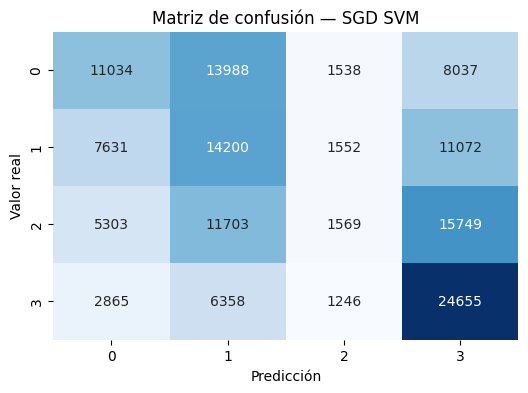

Guardado final_model: sgd_svm_final.joblib
Experimento registrado en experiments.csv


In [ ]:
sample_frac = 0.1
X_sub, _, y_sub, _ = train_test_split(X_train_final, y_train, train_size=sample_frac, random_state=RND, stratify=y_train)

param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2],
    'max_iter': [1000, 3000],
    'tol': [1e-3, 1e-4]
}
sgd = SGDClassifier(loss='hinge', random_state=RND, penalty='l2')

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)
grid = GridSearchCV(sgd, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

t0 = time.time()
grid.fit(X_sub, y_sub)
t1 = time.time()
print("GridSearch terminado en {:.2f} min".format((t1-t0)/60))
print("Mejores params (SGDClassifier):", grid.best_params_)

best_params = grid.best_params_
final_model = SGDClassifier(loss='hinge', random_state=RND, penalty='l2', **best_params)
final_model.fit(X_train_final, y_train)

y_pred_val = final_model.predict(X_val_final)
acc_val = accuracy_score(y_val, y_pred_val)
print("Accuracy en validación (final model):", acc_val)
print(classification_report(y_val, y_pred_val))

cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión — SGD SVM')
plt.show()

joblib.dump(final_model, 'sgd_svm_final.joblib')
print("Guardado final_model: sgd_svm_final.joblib")

exp_row = {
    'notebook': '03 - Target+Freq Encodings + SVM (SGD)',
    'model': 'SGDClassifier (hinge)',
    'params': str(best_params) if 'best_params' in locals() else 'NA',
    'val_accuracy': float(acc_val) if 'acc_val' in locals() else None,
    'test_accuracy': None,
    'kaggle_score': None,
    'model_file': 'sgd_svm_final.joblib',
    'date': datetime.now().isoformat()
}
exp_file = 'experiments.csv'
exp_df = pd.DataFrame([exp_row])
if os.path.exists(exp_file):
    df_exp = pd.read_csv(exp_file)
    df_exp = pd.concat([df_exp, exp_df], ignore_index=True)
else:
    df_exp = exp_df
df_exp.to_csv(exp_file, index=False)
print("Experimento registrado en", exp_file)

# Preparar test_proc_final y generar submission.csv

In [ ]:
test_proc_final = test_proc_final.copy()

preds_num = final_model.predict(test_proc_final)
inv_map = {0:'bajo', 1:'medio-bajo', 2:'medio-alto', 3:'alto'}
preds_text = [inv_map[int(p)] for p in preds_num]

if 'ID' in test_df.columns:
    submission = pd.DataFrame({'ID': test_df['ID'].values, 'RENDIMIENTO_GLOBAL': preds_text})
    out_filename = "submission_sgd_svm_targetfreq.csv"
    submission.to_csv(out_filename, index=False)
    print("Archivo creado:", out_filename, " shape:", submission.shape)
else:
    print("No hay columna ID en test.csv, no se generó submission automaticamente.")

Archivo creado: submission_sgd_svm_targetfreq.csv  shape: (296786, 2)


# Subir a Kaggle

In [ ]:
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f submission_sgd_svm_targetfreq.csv -m "03 SVM Target+Freq Encodings (SGD)"

100% 4.00M/4.00M [00:00<00:00, 15.9MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia